In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_manipulation import transform_data_datetime

# London Rainfall Data

source: [Copernicous Climate Data Store](https://cds.climate.copernicus.eu/)

In [2]:
# Hampstead 51.55338143494524, -0.1778743735609532

data = pd.read_csv('./output/london_weather_dataBACKUP.csv')
data.head()

,time,step,number,surface,latitude,longitude,valid_time,tp,actual_latitude,actual_longitude,target_latitude,target_longitude
0,2021-12-31 18:00:00,0 days 01:00:00,0,0.0,51.6,-0.2,2021-12-31 19:00:00,NaN,51.6,-0.2,51.5074,-0.1278
1,2021-12-31 18:00:00,0 days 12:00:00,0,0.0,51.6,-0.2,2022-01-01 06:00:00,2.868473e-07,51.6,-0.2,51.5074,-0.1278
2,2021-12-31 18:00:00,0 days 11:00:00,0,0.0,51.6,-0.2,2022-01-01 05:00:00,0.000000e+00,51.6,-0.2,51.5074,-0.1278
3,2021-12-31 18:00:00,0 days 10:00:00,0,0.0,51.6,-0.2,2022-01-01 04:00:00,0.000000e+00,51.6,-0.2,51.5074,-0.1278
4,2021-12-31 18:00:00,0 days 08:00:00,0,0.0,51.6,-0.2,2022-01-01 02:00:00,0.000000e+00,51.6,-0.2,51.5074,-0.1278


In [3]:
# data['datetime'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data['valid_datetime'] = pd.to_datetime(data['valid_time'], format='%Y-%m-%d %H:%M:%S')


In [4]:
data.sort_values(by='valid_datetime', inplace=True)
data.reset_index(drop=True, inplace=True)

In [5]:
data.head(5)

,time,step,number,surface,latitude,longitude,valid_time,tp,actual_latitude,actual_longitude,target_latitude,target_longitude,valid_datetime
0,2021-12-31 18:00:00,0 days 01:00:00,0,0.0,51.6,-0.2,2021-12-31 19:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 19:00:00
1,2021-12-31 18:00:00,0 days 02:00:00,0,0.0,51.6,-0.2,2021-12-31 20:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 20:00:00
2,2021-12-31 18:00:00,0 days 03:00:00,0,0.0,51.6,-0.2,2021-12-31 21:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 21:00:00
3,2021-12-31 18:00:00,0 days 04:00:00,0,0.0,51.6,-0.2,2021-12-31 22:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 22:00:00
4,2021-12-31 18:00:00,0 days 05:00:00,0,0.0,51.6,-0.2,2021-12-31 23:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 23:00:00


In [6]:
data['year'] = data['valid_datetime'].dt.year
# data['month int'] = data['valid_datetime'].dt.month
# data['day'] = data['valid_datetime'].dt.day
# data['month'] = data['valid_datetime'].dt.strftime('%b')
# data['month'] = pd.Categorical(data['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

In [7]:
data['RR_mm'] = data['tp'] * 1000

yearly_agg = (data[(data['year'] > 2021) &(data['year'] < 2025)]
              .groupby(['year'], observed=True)
              .agg(
                  RR_mm_total = ('RR_mm', 'sum'),
                  RR_mm_median = ('RR_mm', 'median'),
                  RR_mm_mean = ('RR_mm', 'mean'),
                  RR_mm_max = ('RR_mm', 'max'),
                  RR_mm_min = ('RR_mm', 'min'),
                  )
                  .reset_index()
                  )

yearly_agg.head()

,year,RR_mm_total,RR_mm_median,RR_mm_mean,RR_mm_max,RR_mm_min
0,2022,677.770736,0.000000,0.077371,8.899689,0.0
1,2023,797.295140,0.000387,0.091015,5.163908,0.0
2,2024,846.405576,0.001252,0.096358,4.390955,0.0


In [8]:
data['DATE'] = data['valid_datetime'].dt.date


In [9]:
daily_total_precipitation = (data[(data['year'] > 2021) &(data['year'] < 2025)]
 .groupby('DATE', observed=True)
 .agg(
     RR_daily_total=('RR_mm', 'sum'),
     RR_daily_max=('RR_mm', 'max'),
     )
     .reset_index()
)

In [11]:
# daily_total_precipitation = transform_data_datetime(daily_total_precipitation)

In [12]:
daily_total_precipitation['year'].unique()

KeyError: 'year'

In [ ]:
daily_total_precipitation.head()

### London New Source

- [Copernicus Reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)

In [13]:
# creating a function transforming the data format in a more
# convenient way for furhter analysis

# steps
## valid_time -> datetime
## tp -> RR_mm

def transform_data_to_complete_dataset(df):
    '''
    First step in transforming raw data
    it takes the dataframe and creates a new dataframe with the following columns:
    - valid_time: datetime object
    - RR_mm: precipitation in mm (converted from tp)
    - t2m_celsius: temperature in Celsius (converted from t2m)
    '''
    df = df.copy()
    df['valid_time'] = pd.to_datetime(df['valid_time'], format='%Y-%m-%d %H:%M:%S')
    df['valid_datetime'] = df['valid_time'].dt.date
    
    df.sort_values(by='valid_time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['RR_mm'] = df['tp'] * 1000  # Convert tp from m to mm
    df['t2m_celsius'] = df['t2m'] - 273.15  # Convert temperature from Kelvin to Celsius
    df.sort_values(by='valid_time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df[['valid_time', 'valid_datetime', 'RR_mm', 't2m_celsius', 'tp', 't2m', 'longitude', 'latitude']]

In [14]:
def create_daily_aggregated_dataset(df, start_year = 0, end_year = 9999):
    if start_year == 0:
        start_year = df['valid_time'].min().year
    if end_year == 9999:
        end_year = df['valid_time'].max().year
    df = df[df['valid_time'].dt.year.between(start_year, end_year)]
    df_daily = df.groupby('valid_datetime').agg(
        valid_time=('valid_time', 'first'),
        RR_mm=('RR_mm', 'sum'),
        t2m_celsius_mean=('t2m_celsius', 'mean'),
        t2m_celsius_min=('t2m_celsius', 'min'),
        t2m_celsius_max=('t2m_celsius', 'max'),
        longitude=('longitude', 'first'),
        latitude=('latitude', 'first')
        ).reset_index().round(2)
    return df_daily

In [15]:
def transform_data_datetime_test(df, date_column='DATE', datetime_format=True):   
    df = df.copy()
    if datetime_format:
        df['year'] = df[date_column].dt.year
        df['month int'] = df[date_column].dt.month
        df['month'] = df[date_column].dt.strftime('%b')
        df['day'] = df[date_column].dt.day

        return df
    # df['datetime'] = pd.to_datetime(df[date_column], format="%Y%m%d")
    df['datetime'] = pd.to_datetime(df[date_column], format="%Y%m%d")
    df['year'] = df['datetime'].dt.year
    df['month int'] = df['datetime'].dt.month
    df['month'] = df['datetime'].dt.strftime('%b')
    df['day'] = df['datetime'].dt.day

    return df[['datetime', 'valid_time', 'year', 'month','day','RR_mm', 't2m_celsius_mean', 't2m_celsius_min', 't2m_celsius_max', 'month int', 'longitude', 'latitude']]

In [22]:
#  reanalysis-era5-single-levels-timeseries-london.csv

london_data = pd.read_csv('./data/reanalysis-era5-single-levels-timeseries-london.csv')
print(london_data.shape)
london_data.tail()

(749112, 5)


,valid_time,t2m,tp,latitude,longitude
749107,2025-06-15 19:00:00,293.93137,0.0,51.5,0.25
749108,2025-06-15 20:00:00,292.31067,0.0,51.5,0.25
749109,2025-06-15 21:00:00,290.81696,0.0,51.5,0.25
749110,2025-06-15 22:00:00,289.76280,0.0,51.5,0.25
749111,2025-06-15 23:00:00,288.88483,0.0,51.5,0.25


In [23]:
london_data[london_data['tp'].isna()]

,valid_time,t2m,tp,latitude,longitude
0,1940-01-01 00:00:00,272.52448,NaN,51.5,0.25
1,1940-01-01 01:00:00,271.53430,NaN,51.5,0.25
2,1940-01-01 02:00:00,270.50958,NaN,51.5,0.25
3,1940-01-01 03:00:00,270.18396,NaN,51.5,0.25
4,1940-01-01 04:00:00,270.18094,NaN,51.5,0.25
5,1940-01-01 05:00:00,269.76892,NaN,51.5,0.25
6,1940-01-01 06:00:00,270.24026,NaN,51.5,0.25
7,1940-01-01 07:00:00,271.52478,NaN,51.5,0.25
8,1940-01-01 08:00:00,272.91467,NaN,51.5,0.25
9,1940-01-01 09:00:00,273.33040,NaN,51.5,0.25


In [24]:
df_london = transform_data_to_complete_dataset(london_data)

In [25]:
df_london.head()

,valid_time,valid_datetime,RR_mm,t2m_celsius,tp,t2m,longitude,latitude
0,1940-01-01 00:00:00,1940-01-01,NaN,-0.62552,NaN,272.52448,0.25,51.5
1,1940-01-01 01:00:00,1940-01-01,NaN,-1.61570,NaN,271.53430,0.25,51.5
2,1940-01-01 02:00:00,1940-01-01,NaN,-2.64042,NaN,270.50958,0.25,51.5
3,1940-01-01 03:00:00,1940-01-01,NaN,-2.96604,NaN,270.18396,0.25,51.5
4,1940-01-01 04:00:00,1940-01-01,NaN,-2.96906,NaN,270.18094,0.25,51.5


In [26]:
daily_aggregate_london = create_daily_aggregated_dataset(df_london, start_year=1960)

In [29]:
daily_aggregate_london = transform_data_datetime_test(daily_aggregate_london, date_column='valid_time', datetime_format=False)

In [31]:
london_yearly_aggregate = (daily_aggregate_london
                           .groupby(['year'])
                           .agg(
                               RR_yearly_sum=('RR_mm', 'sum'),
                               t2m_celsius_yearly_mean=('t2m_celsius_mean', 'mean'),
                               t2m_celsius_yearly_min=('t2m_celsius_min', 'min'),
                               t2m_celsius_yearly_max=('t2m_celsius_max', 'max')
                               ).reset_index()
                               )


In [32]:
london_yearly_aggregate.head()

,year,RR_yearly_sum,t2m_celsius_yearly_mean,t2m_celsius_yearly_min,t2m_celsius_yearly_max
0,1960,701.41,9.965191,-5.05,25.35
1,1961,523.58,10.720000,-4.48,29.37
2,1962,543.88,8.848877,-5.97,23.31
3,1963,577.73,8.559863,-11.87,25.02
4,1964,541.26,9.732077,-6.81,27.17


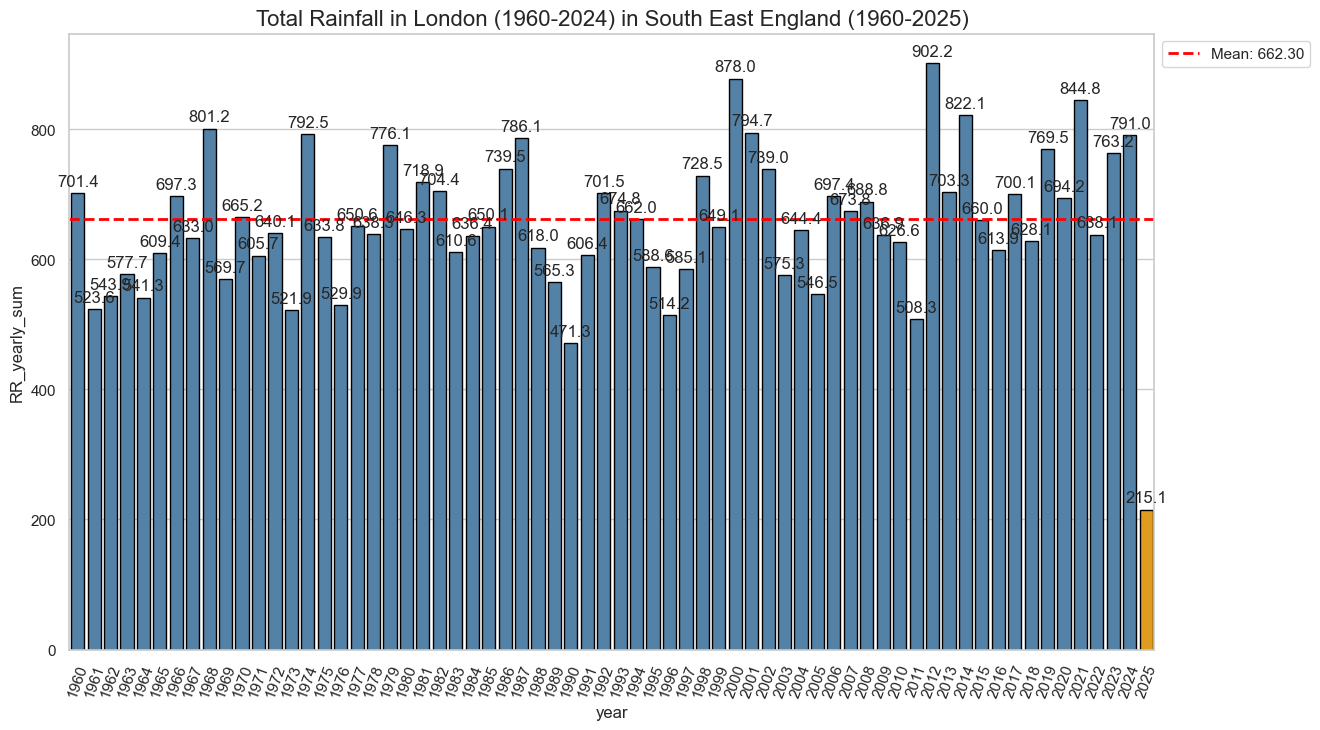

In [42]:
from src.data_plotting import plot_rainfall
plot_rainfall(london_yearly_aggregate,
              start_year=1960,latest_year=2025,feature='RR_yearly_sum',
              special_year=2026, title_label='Total Rainfall in London (1960-2024)',
              rotation_x_label=70,
              fig_size=(14,8))

In [43]:
data.head()

,time,step,number,surface,latitude,longitude,valid_time,tp,actual_latitude,actual_longitude,target_latitude,target_longitude,valid_datetime,year,RR_mm,DATE
0,2021-12-31 18:00:00,0 days 01:00:00,0,0.0,51.6,-0.2,2021-12-31 19:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 19:00:00,2021,NaN,2021-12-31
1,2021-12-31 18:00:00,0 days 02:00:00,0,0.0,51.6,-0.2,2021-12-31 20:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 20:00:00,2021,NaN,2021-12-31
2,2021-12-31 18:00:00,0 days 03:00:00,0,0.0,51.6,-0.2,2021-12-31 21:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 21:00:00,2021,NaN,2021-12-31
3,2021-12-31 18:00:00,0 days 04:00:00,0,0.0,51.6,-0.2,2021-12-31 22:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 22:00:00,2021,NaN,2021-12-31
4,2021-12-31 18:00:00,0 days 05:00:00,0,0.0,51.6,-0.2,2021-12-31 23:00:00,NaN,51.6,-0.2,51.5074,-0.1278,2021-12-31 23:00:00,2021,NaN,2021-12-31
